## GB_Fx-Quarterly_Macro


Data (B): 2000-01-31 → 2025-11-10 | n=6726
Data (D): 2000-01-31 → 2025-11-10 | n=9416
Columns (DF_d): ['d_pi', 'dI_t', 'EUR_NOK', 'Q']

Dropped quarters and reasons:
  2000Q1: no_cut_in_prev_quarter

=== Model performance (quarterly mean, EUR/NOK – XGB Price only with past macros) ===
Observations: 103
RMSE (level): 0.272917
MAE  (level): 0.173140
Directional accuracy: 75/102 (73.5%)

=== Diebold–Mariano vs Random Walk (XGB Price only w/ past macros, quarterly) ===
Loss: MSE | horizon h=1
DM-statistic: 0.8300
p-value     : 0.4065


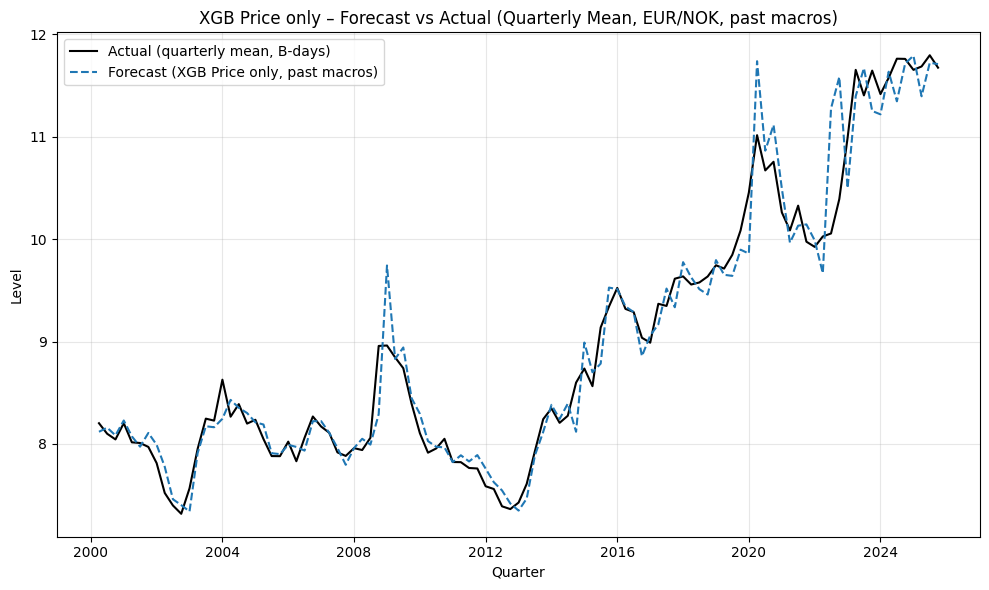

Saved PNG: XGB_PriceOnly_Quarterly_PastMacroCov.png


In [1]:
# =========================================
# XGB Price-only – EUR/NOK walk-forward (quarterly, levels) with daily past macro covariates
# PARALLEL OUTER LOOP
# Univariate setup:
#   - Target: EUR_NOK (single series)
#   - Macros: Q, d_pi, dI_t included as past-only covariates
#   - Data: daily (calendar days), forward-filled
#   - Cut: last business day of previous quarter (based on EUR_NOK B-days)
#   - Forecast: next calendar quarter at daily frequency (recursive one-step XGB),
#               aggregated to quarterly mean over business days (EUR/NOK)
#   - No future macro paths used -> macros frozen at last observed value during recursion
#   - Metrics: Observations, RMSE, MAE, Directional accuracy
#   - Test: Diebold–Mariano vs Random Walk (MSE, h=1)
#   - Plot: Actual (black) vs Forecast (blue dashed), no intervals
#   - Constraint: n_estimators fixed to 150 (per tuning design)
#   - History requirement MATCHES RW: min_hist_days=40 before each cut
#   - Output: save ONLY PNG as "XGB_PriceOnly_Quarterly_PastMacroCov.png"
# =========================================

!pip -q install pandas numpy scikit-learn matplotlib requests certifi joblib xgboost

from __future__ import annotations
import io, time, math
from dataclasses import dataclass
from typing import Optional, Tuple, Dict, List

import numpy as np
import pandas as pd
import requests, certifi
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from joblib import Parallel, delayed


# -----------------------------
# Configuration
# -----------------------------
@dataclass
class Config:
    url: str = (
        "https://raw.githubusercontent.com/bredeespelid/"
        "Data_MasterOppgave/refs/heads/main/Variables/All_Variables/variables_daily.csv"
    )

    q_freq: str = "Q-DEC"
    max_lags: int = 20
    max_horizon: int = 128  # guard for long quarters
    min_hist_days: int = 40  # match RW history rule

    # Tuned XGB hyperparameters (random search, pre-eval panel)
    n_estimators: int = 150
    learning_rate: float = 0.04
    max_depth: int = 6
    min_child_weight: float = 7.0
    subsample: float = 0.6
    colsample_bytree: float = 1.0
    gamma: float = 0.05
    reg_alpha: float = 0.2
    reg_lambda: float = 0.5
    random_state: int = 42

    retries: int = 3
    timeout: int = 60
    verbose: bool = True

    fig_png: str = "XGB_PriceOnly_Quarterly_PastMacroCov.png"


CFG = Config()

TARGET_SERIES = "EUR_NOK"
MACRO_COLS = ["Q", "d_pi", "dI_t"]


# -----------------------------
# Download helper
# -----------------------------
def download_csv_text(url: str, retries: int, timeout: int) -> str:
    """Download CSV with simple retry/backoff."""
    last_err = None
    for k in range(1, retries + 1):
        try:
            r = requests.get(url, timeout=timeout, verify=certifi.where())
            r.raise_for_status()
            return r.text
        except Exception as e:
            last_err = e
            if k < retries:
                wait = 1.5 * k
                print(f"[warning] Download failed (try {k}/{retries}): {e}. Retrying in {wait:.1f}s ...")
                time.sleep(wait)
    raise RuntimeError(f"Download failed: {last_err}")


# -----------------------------
# Data loading (daily calendar + business-day target)
# -----------------------------
def load_series(url: str) -> Tuple[pd.Series, pd.DataFrame]:
    """
    Load daily CSV with columns:
      Date, EUR_NOK, Q, d_pi, dI_t

    Returns:
      S_b  : EUR_NOK on business days (B) with ffill (cuts + quarterly truth)
      DF_d : daily (D) DataFrame with columns [EUR_NOK, Q, d_pi, dI_t],
             calendar days, forward-filled
    """
    text = download_csv_text(url, CFG.retries, CFG.timeout)
    raw = pd.read_csv(io.StringIO(text))

    required_cols = {"Date", "EUR_NOK", "Q", "d_pi", "dI_t"}
    missing = required_cols - set(raw.columns)
    if missing:
        raise ValueError(f"Missing columns in CSV: {missing}. Got: {list(raw.columns)}")

    df = (
        raw[list(required_cols)]
        .rename(columns={"Date": "DATE"})
        .assign(DATE=lambda x: pd.to_datetime(x["DATE"], errors="coerce"))
        .dropna(subset=["DATE", TARGET_SERIES])
        .sort_values("DATE")
        .set_index("DATE")
    )

    for col in [TARGET_SERIES] + MACRO_COLS:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    df = df.dropna(subset=[TARGET_SERIES])

    if df.empty:
        raise ValueError("Dataset is empty after cleaning.")

    # Business-day EUR_NOK (truth / aggregation base)
    S_b = df[TARGET_SERIES].asfreq("B").ffill().astype(float)
    S_b.name = TARGET_SERIES

    # Calendar-day DF_d (forward-filled)
    full_idx = pd.date_range(df.index.min(), df.index.max(), freq="D")
    DF_d = df.reindex(full_idx).ffill()
    DF_d.index.name = "DATE"

    return S_b, DF_d


def last_trading_day(S_b: pd.Series, start: pd.Timestamp, end: pd.Timestamp) -> Optional[pd.Timestamp]:
    """Return the last business day in [start, end]."""
    sl = S_b.loc[start:end]
    return sl.index[-1] if not sl.empty else None


# -----------------------------
# Feature engineering (stacked multivariate lags)
# -----------------------------
def make_lag_matrix(df_hist: pd.DataFrame, max_lags: int) -> Tuple[np.ndarray, np.ndarray, List[str]]:
    """
    Build X, y for one-step ahead daily forecasting.

    X_t = stacked lags of:
      [EUR_NOK_{t-1..t-L}, Q_{t-1..t-L}, d_pi_{t-1..t-L}, dI_t_{t-1..t-L}]
    y_t = EUR_NOK_t
    """
    work = df_hist[[TARGET_SERIES] + MACRO_COLS].copy()
    lag_cols: List[str] = []

    for var in [TARGET_SERIES] + MACRO_COLS:
        for k in range(1, max_lags + 1):
            name = f"{var}_lag{k}"
            work[name] = work[var].shift(k)
            lag_cols.append(name)

    work = work.dropna()
    X = work[lag_cols].values
    y = work[TARGET_SERIES].values
    return X, y, lag_cols


# -----------------------------
# XGBoost one-step model
# -----------------------------
def fit_xgb_one_step(df_hist_daily: pd.DataFrame) -> Tuple[XGBRegressor, List[str]]:
    """Fit XGB for one-step daily prediction using lagged EUR_NOK and lagged macros."""
    X, y, lag_cols = make_lag_matrix(df_hist_daily, CFG.max_lags)

    if len(X) < 5:
        raise ValueError("Too few observations after lagging to fit model.")

    model = XGBRegressor(
        n_estimators=CFG.n_estimators,
        learning_rate=CFG.learning_rate,
        max_depth=CFG.max_depth,
        min_child_weight=CFG.min_child_weight,
        subsample=CFG.subsample,
        colsample_bytree=CFG.colsample_bytree,
        gamma=CFG.gamma,
        reg_alpha=CFG.reg_alpha,
        reg_lambda=CFG.reg_lambda,
        objective="reg:squarederror",
        eval_metric="rmse",
        tree_method="hist",
        random_state=CFG.random_state,
        n_jobs=1
    )
    model.fit(X, y)
    return model, lag_cols


def recursive_daily_forecast(
    model: XGBRegressor,
    df_hist_daily: pd.DataFrame,
    H: int
) -> pd.Series:
    """
    Produce H daily forecasts recursively.

    Anti-leakage:
      - macros frozen at last observed value
      - only EUR_NOK updated during recursion
    """
    hist = df_hist_daily[[TARGET_SERIES] + MACRO_COLS].copy()
    last_macros = hist[MACRO_COLS].iloc[-1].to_dict()

    preds = []
    for _ in range(H):
        if len(hist) < CFG.max_lags:
            raise ValueError("Not enough history for lag features.")

        row_feats = []
        for var in [TARGET_SERIES] + MACRO_COLS:
            lags = hist[var].iloc[-CFG.max_lags:][::-1].values
            row_feats.extend(lags.tolist())

        x = np.array(row_feats, dtype=float).reshape(1, -1)
        yhat = float(model.predict(x)[0])
        preds.append(yhat)

        new_row = {TARGET_SERIES: yhat, **last_macros}
        hist = pd.concat(
            [hist, pd.DataFrame([new_row], index=[hist.index[-1] + pd.Timedelta(days=1)])]
        )

    return pd.Series(preds)


# -----------------------------
# Quarterly walk-forward (parallel outer loop)
# -----------------------------
def walk_forward_xgb_quarterly_pastcov_parallel(
    S_b: pd.Series,
    DF_d: pd.DataFrame,
    n_jobs_outer: int = -1,
    backend: str = "loky"
) -> pd.DataFrame:
    """
    For each calendar quarter q:
      - cut at last business day of previous quarter
      - require >= min_hist_days observations before cut
      - fit XGB on daily history up to cut
      - recursively forecast full next quarter daily
      - aggregate to business-day quarterly mean and compare to truth
    """
    first_q = pd.Period(S_b.index.min(), freq=CFG.q_freq)
    last_q  = pd.Period(S_b.index.max(), freq=CFG.q_freq)
    quarters = pd.period_range(first_q, last_q, freq=CFG.q_freq)

    def _process_one_quarter(q: pd.Period):
        prev_q = q - 1
        q_start, q_end = q.start_time, q.end_time
        prev_start, prev_end = prev_q.start_time, prev_q.end_time

        cut = last_trading_day(S_b, prev_start, prev_end)
        if cut is None:
            return (str(q), None, "no_cut_in_prev_quarter")

        hist_df = DF_d.loc[:cut]

        if hist_df.shape[0] < CFG.min_hist_days:
            return (str(q), None, f"hist<{CFG.min_hist_days}")

        if hist_df.shape[0] <= CFG.max_lags:
            return (str(q), None, "hist<=max_lags")

        idx_q_b = S_b.index[(S_b.index >= q_start) & (S_b.index <= q_end)]
        if idx_q_b.size < 1:
            return (str(q), None, "no_bdays_in_quarter")
        y_true = float(S_b.loc[idx_q_b].mean())

        H = (q_end.date() - q_start.date()).days + 1
        if H <= 0 or H > CFG.max_horizon:
            return (str(q), None, f"horizon_invalid(H={H})")

        model, _ = fit_xgb_one_step(hist_df)
        pf = recursive_daily_forecast(model, hist_df, H)

        f_idx = pd.date_range(cut + pd.Timedelta(days=1), periods=H, freq="D")
        pred_daily = pd.Series(pf.values, index=f_idx, name="point")

        pred_b = pred_daily.reindex(idx_q_b, method=None)
        if pred_b.isna().all():
            return (str(q), None, "no_overlap_pred_B_days")
        y_pred = float(pred_b.dropna().mean())

        row = {"quarter": q, "cut": cut, "y_true": y_true, "y_pred": y_pred}
        return (str(q), row, None)

    results = Parallel(n_jobs=n_jobs_outer, backend=backend)(
        delayed(_process_one_quarter)(q) for q in quarters
    )

    rows: Dict[str, dict] = {}
    dropped: Dict[str, str] = {}

    for key, row, reason in results:
        if row is not None:
            rows[key] = row
        else:
            dropped[key] = reason or "unknown"

    df = pd.DataFrame.from_dict(rows, orient="index")
    if not df.empty:
        df = df.set_index("quarter").sort_index()

    if CFG.verbose and dropped:
        miss = [str(q) for q in quarters if str(q) not in rows]
        if miss:
            print("\nDropped quarters and reasons:")
            for qq in miss:
                print(f"  {qq}: {dropped.get(qq, 'unknown')}")

    return df


# -----------------------------
# Evaluation (levels + direction)
# -----------------------------
def evaluate(eval_df: pd.DataFrame) -> pd.DataFrame:
    df = eval_df.copy()
    df["err"] = df["y_true"] - df["y_pred"]
    core = df.dropna(subset=["y_true", "y_pred"]).copy()

    n_obs = int(len(core))
    rmse = float(np.sqrt(np.mean(np.square(core["err"])))) if n_obs else np.nan
    mae  = float(mean_absolute_error(core["y_true"], core["y_pred"])) if n_obs else np.nan

    core["y_prev"] = core["y_true"].shift(1)
    mask = core["y_prev"].notna()
    dir_true = np.sign(core.loc[mask, "y_true"] - core.loc[mask, "y_prev"])
    dir_pred = np.sign(core.loc[mask, "y_pred"] - core.loc[mask, "y_prev"])
    hits = int((dir_true.values == dir_pred.values).sum())
    total = int(mask.sum())
    hit_rate = (hits / total) if total else np.nan

    print("\n=== Model performance (quarterly mean, EUR/NOK – XGB Price only with past macros) ===")
    print(f"Observations: {n_obs}")
    print(f"RMSE (level): {rmse:.6f}")
    print(f"MAE  (level): {mae:.6f}")
    if total:
        print(f"Directional accuracy: {hits}/{total} ({hit_rate*100:.1f}%)")

    return core


# -----------------------------
# Diebold–Mariano vs Random Walk
# -----------------------------
def _normal_cdf(z: float) -> float:
    return 0.5 * (1.0 + math.erf(z / math.sqrt(2.0)))

def dm_test(
    y_true: pd.Series,
    y_model: pd.Series,
    y_rw: pd.Series,
    h: int = 1,
    loss: str = "mse"
) -> Tuple[float, float]:
    df = pd.concat({"y": y_true, "m": y_model, "rw": y_rw}, axis=1).dropna()
    if df.empty or len(df) < 5:
        return float("nan"), float("nan")

    e_m = df["y"] - df["m"]
    e_r = df["y"] - df["rw"]
    d = np.abs(e_m) - np.abs(e_r) if loss.lower() == "mae" else (e_m**2) - (e_r**2)

    N = int(len(d))
    d_mean = float(d.mean())
    gamma0 = float(np.var(d, ddof=1)) if N > 1 else 0.0
    var_bar = gamma0 / N

    if h > 1 and N > 2:
        for k in range(1, min(h - 1, N - 1) + 1):
            w_k = 1.0 - k / h
            cov_k = float(np.cov(d[k:], d[:-k], ddof=1)[0, 1])
            var_bar += 2.0 * w_k * cov_k / N

    if var_bar <= 0 or not np.isfinite(var_bar):
        return float("nan"), float("nan")

    dm_stat = d_mean / math.sqrt(var_bar)
    p_val = 2.0 * (1.0 - _normal_cdf(abs(dm_stat)))
    return dm_stat, p_val

def dm_against_random_walk(eval_df: pd.DataFrame, loss: str = "mse", h: int = 1) -> None:
    df = eval_df.copy()
    df["rw_pred"] = df["y_true"].shift(1)
    dm_stat, p_val = dm_test(df["y_true"], df["y_pred"], df["rw_pred"], h=h, loss=loss)

    print("\n=== Diebold–Mariano vs Random Walk (XGB Price only w/ past macros, quarterly) ===")
    print(f"Loss: {loss.upper()} | horizon h={h}")
    print(f"DM-statistic: {dm_stat:.4f}" if np.isfinite(dm_stat) else "DM-statistic: nan")
    print(f"p-value     : {p_val:.4f}" if np.isfinite(p_val) else "p-value     : nan")


# -----------------------------
# Plot (PNG only)
# -----------------------------
def plot_quarterly_simple(eval_df: pd.DataFrame, png_path: str):
    if eval_df.empty:
        print("Nothing to plot.")
        return

    plt.figure(figsize=(10, 6))
    x = eval_df.index.to_timestamp() if isinstance(eval_df.index, pd.PeriodIndex) else eval_df.index

    plt.plot(x, eval_df["y_true"], color="black", label="Actual (quarterly mean, B-days)")
    plt.plot(
        x, eval_df["y_pred"],
        color="tab:blue", linestyle="--",
        label="Forecast (XGB Price only, past macros)"
    )

    plt.title("XGB Price only – Forecast vs Actual (Quarterly Mean, EUR/NOK, past macros)")
    plt.xlabel("Quarter")
    plt.ylabel("Level")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    plt.savefig(png_path, dpi=300, bbox_inches="tight")
    plt.show()
    print(f"Saved PNG: {png_path}")


# -----------------------------
# Main
# -----------------------------
def main():
    S_b, DF_d = load_series(CFG.url)
    if CFG.verbose:
        print(f"Data (B): {S_b.index.min().date()} → {S_b.index.max().date()} | n={len(S_b)}")
        print(f"Data (D): {DF_d.index.min().date()} → {DF_d.index.max().date()} | n={len(DF_d)}")
        print(f"Columns (DF_d): {list(DF_d.columns)}")

    df_eval = walk_forward_xgb_quarterly_pastcov_parallel(S_b, DF_d, n_jobs_outer=-1)
    eval_df = evaluate(df_eval)

    dm_against_random_walk(eval_df, loss="mse", h=1)
    plot_quarterly_simple(eval_df, CFG.fig_png)

if __name__ == "__main__":
    main()
